In [12]:
PATH_FRC = ""
PATH_DATA = ""
PATH_MODELS = ""

In [23]:
import os
import sys
import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
from skimage.filters import gaussian
from skimage.transform import rescale, resize
from skimage.filters import window
import bm3d

#provide path to the frc git repository
sys.path.append(PATH_FRC)

from models2 import FRCUnetModel

matplotlib.rcParams.update({'mathtext.default':'regular'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'legend.fontsize': 8})
matplotlib.rcParams.update({'axes.labelweight': 'bold'})

In [18]:
def normalise_img(image):
    image = image - image.min()
    image = image/image.max() - 0.5
    return image

def load_model(model_dir, model_fname):
    if model_dir is not None:
        return FRCUnetModel(None, model_path=os.path.join(model_dir, model_fname))
      
def fourier_ring_correlation_by_ring(image1, image2, rn, spatial_freq):
    # we need the channels first format for this loss
    image1 = tf.transpose(image1, perm=[0, 3, 1, 2])
    image2 = tf.transpose(image2, perm=[0, 3, 1, 2])
    image1 = tf.cast(image1, tf.complex64)
    image2 = tf.cast(image2, tf.complex64)
    
    rn = tf.cast(rn, tf.complex64)
    fft_image1 = tf.signal.fftshift(tf.signal.fft2d(image1), axes=[2, 3])
    fft_image2 = tf.signal.fftshift(tf.signal.fft2d(image2), axes=[2, 3])

    t1 = tf.multiply(fft_image1, rn)  # (128, BS?, 3, 256, 256)
    t2 = tf.multiply(fft_image2, rn)
    c1 = tf.math.real(tf.reduce_sum(tf.multiply(t1, tf.math.conj(t2)), [2, 3, 4]))
    c2 = tf.reduce_sum(tf.math.abs(t1) ** 2, [2, 3, 4])
    c3 = tf.reduce_sum(tf.math.abs(t2) ** 2, [2, 3, 4])
    frc = tf.math.divide(c1, tf.math.sqrt(tf.math.multiply(c2, c3)))
    frc = tf.where(tf.compat.v1.is_inf(frc), tf.zeros_like(frc), frc)  # inf
    frc = tf.where(tf.compat.v1.is_nan(frc), tf.zeros_like(frc), frc)  # nan
    return frc  

def make_set(input1,input2,dataset,radial_masks,spatial_freq):
    output=[]
    print(dataset)
    for i in tqdm(range(50)):
        if dataset == 'noisy_noisy':
            denoised = input2[i]
        elif dataset == 'noisy_gt':
            denoised = input2[i]
        elif dataset == 'denoised_n2n':
            denoised = l2_model.model(np.reshape(input2[i], [1,256, 256,1]))
            denoised = np.squeeze(denoised)
        elif dataset == 'denoised_n2n_1000':
            denoised = l2_1000_model.model(np.reshape(input2[i], [1,256, 256,1]))
            denoised = np.squeeze(denoised)  
        elif dataset == 'denoised_gaussian':
            denoised = gaussian(input2[i],sigma=1,mode='wrap',cval=0)            
        elif dataset == 'denoised_bm3d':
            denoised = bm3d.bm3d(input2[i], sigma_psd=0.4, stage_arg=bm3d.BM3DStages.ALL_STAGES)
   
        frc = fourier_ring_correlation_by_ring(np.reshape(input1[i], [1,256, 256,1]), np.reshape(denoised,\
                                        [1,256, 256,1]), radial_masks, spatial_freq)
        output.append(frc.numpy().T[0])
        
    output=np.stack(output)
    output=output.mean(axis=0)
    return output 

# Models

In [8]:
l2_model=load_model(PATH_MODELS+/models/l2/noise04/', 'saved-model-epoch-200')

In [9]:
l2_1000_model=load_model(PATH_MODELS+'/models/l2_1000/models/1/', 'saved-model-epoch-200')

# Data preprocessing

In [15]:
files=sorted(glob.glob(PATH_DATA+'/*'))
clean_images=[]

for file in files:
    clean = imread(file)
    if len(clean.shape) > 2:
        clean = np.mean(clean, axis=2)
    minsize = np.array(clean.shape).min()
    clean = clean[:minsize,:minsize]
    clean = tf.convert_to_tensor(clean)
    clean = clean[tf.newaxis, ..., tf.newaxis]
    clean = tf.image.resize(
        clean, [256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, preserve_aspect_ratio=True, \
        antialias=False, name=None)
    clean=clean.numpy().squeeze()
    clean = normalise_img(clean)
    clean = clean.astype('float32')
    clean = clean*window('hann', clean.shape) 
    clean_images.append(clean)

clean_images = np.stack(clean_images)
clean_images = clean_images[:50,:,:]

In [17]:
noisy_images1 = clean_images.copy() + np.random.normal(0,0.4,256**2*50).reshape(50,256,256)
noisy_images2 = clean_images.copy() + np.random.normal(0,0.4,256**2*50).reshape(50,256,256)

In [24]:
rm = l2_model.radial_masks
sf = l2_model.spatial_freq

noisy_noisy = make_set(noisy_images1,noisy_images2,'noisy_noisy',rm,sf)
noisy_gt = make_set(clean_images,noisy_images1,'noisy_gt',rm,sf)
denoised_n2n = make_set(clean_images,noisy_images1,'denoised_n2n',rm,sf)
denoised_n2n_1000 = make_set(clean_images,noisy_images1,'denoised_n2n_1000',rm,sf)
denoised_gaussian = make_set(clean_images,noisy_images1,'denoised_gaussian',rm,sf)
denoised_bm3d = make_set(clean_images,noisy_images2,'denoised_bm3d',rm,sf)

data=pd.DataFrame([noisy_noisy, noisy_gt, denoised_n2n, denoised_n2n_1000, denoised_gaussian, denoised_bm3d]).T
data.columns=['noisy_noisy', 'noisy_gt', 'denoised_n2n', 'denoised_n2n_1000', 'denoised_gaussian', 'denoised_bm3d']

  0%|          | 0/50 [00:00<?, ?it/s]

noisy_noisy


  2%|▏         | 1/50 [00:00<00:09,  5.12it/s]

noisy_gt


  0%|          | 0/50 [00:00<?, ?it/s]

denoised_n2n


  0%|          | 0/50 [00:00<?, ?it/s]

denoised_n2n_1000


  2%|▏         | 1/50 [00:00<00:09,  5.39it/s]

denoised_gaussian


  0%|          | 0/50 [00:00<?, ?it/s]

denoised_bm3d


100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


# Figure bottom

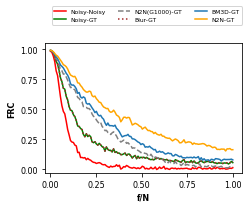

In [25]:
fig = plt.figure()
fig.set_size_inches(3.5, 2.9)
ax = fig.add_subplot(111)

ax.plot(data.index/data.index.max(),data['noisy_noisy'] , label='Noisy-Noisy', lw=1.5, c='red')
ax.plot(data.index/data.index.max(),data['noisy_gt'] , label='Noisy-GT', lw=1.5, c='green')
ax.plot(data.index/data.index.max(),data['denoised_n2n_1000'] , label='N2N(G1000)-GT', lw=1.5, c='gray', ls='dashed')
ax.plot(data.index/data.index.max(),data['denoised_gaussian'] , label='Blur-GT', lw=1.5, c='brown', ls='dotted')
ax.plot(data.index/data.index.max(),data['denoised_bm3d'] , label='BM3D-GT', lw=1.5)
ax.plot(data.index/data.index.max(),data['denoised_n2n'] , label='N2N-GT', lw=1.5, c='orange')

ax.set_xlabel('f/N')
ax.set_ylabel('FRC')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.ylim([-0.03,1.05])
plt.xlim([-0.03,1.05])

legend_properties = { 'size':6}
ax.legend(prop=legend_properties, loc=1, ncol=3, bbox_to_anchor=(1.015, 1.31) )
fig.tight_layout()
plt.tight_layout()
fig.savefig('figure_2b.png', dpi=300) 

locs, labels = plt.xticks()

# Figure top

In [30]:
hause = imread('./c0911b81ee5266fa.jpg')
hause = np.mean(hause, axis=2)[:,:]
hause = normalise_img(hause)
hause = hause.astype('float')
hause = hause[:np.min(hause.shape),:np.min(hause.shape)]

hause = hause[230:,180:]
hause = hause[:256,:256]

noisy_hause = hause + np.random.normal(0,0.4,256**2).reshape(256,256)
denoised_hause = l2_model.model(np.reshape(noisy_hause, [1, 256, 256, 1]))
denoised_hause = np.squeeze(denoised_hause)
denoised_hause = normalise_img(denoised_hause)
noisy_hause = normalise_img(noisy_hause)

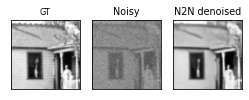

In [31]:
fig = plt.figure(figsize=(2*1.75, 1.35*1))

ax1 = fig.add_subplot(131)
ax1.imshow(hause[:,:], cmap='gray')
plt.xticks([])
plt.yticks([])
ax1.set_title('GT', size=8)

ax2 = fig.add_subplot(132)
ax2.imshow(noisy_hause[:,:], cmap='gray')
ax2.set_title('Noisy')
plt.xticks([])
plt.yticks([])

ax3 = fig.add_subplot(133)
ax3.imshow(denoised_hause[:,:], cmap='gray')
ax3.set_title('N2N denoised')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
fig.savefig('figure_2a.png', dpi=300)